In [11]:
import numpy as np
import pandas as pd
import plotnine as pn

import matplotlib.pyplot as plt

from sciterra import Atlas, Cartographer
from sciterra.vectorization import SciBERTVectorizer

In [12]:
atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=hafenLowredshiftLymanLimit2017"

In [13]:
atl = Atlas.load(atlas_dir)
len(atl)

10004

In [14]:
print(atl.history.keys())
kernels = atl.history['kernel_size']
print(kernels.shape)
len(atl.history['pubs_per_update'])

dict_keys(['pubs_per_update', 'kernel_size'])
(10004, 46)


47

In [15]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration

In [16]:
np.set_printoptions(suppress=True)
np.array([np.mean(kernels[:, i]) for i in range(kernels.shape[1])])

array([  -0.9840064 ,   -0.91323471,   -0.8597561 ,   -0.79948021,
         -0.71821271,   -0.64194322,   -0.53108756,   -0.40233906,
         -0.21341463,   -0.02289084,    0.27179128,    0.74960016,
          0.9880048 ,    1.45691723,    4.01539384,    4.34936026,
          4.52618952,    4.6477409 ,    4.74430228,    4.86645342,
          4.98180728,    5.12295082,    5.48210716,    5.61735306,
          5.76129548,    5.92343063,    6.18812475,    6.66913235,
          6.95781687,    7.36065574,    7.93352659,    8.94402239,
         10.06707317,   14.94212315,   17.21821271,   20.21401439,
         25.80117953,   40.15633747,   53.70841663,   75.45251899,
        135.02768892,  247.79658137,  552.41453419,  581.3752499 ,
        643.12005198, 1175.32447021])

In [17]:
df_kernel_evolution = pd.DataFrame(
    [
        (
            i+1, 
            np.mean(kernels[:, i]), 
            np.sum(kernels[:, i] >= 1),
            np.sum(kernels[:, i] >= 10),
            np.sum(kernels[:, i] >= 100),
            np.sum(kernels[:, i] >= 1000),
        ) 
        for i in range(kernels.shape[1])],
    columns=[
        "expansion", 
        "avg_converged_kernel_size", 
        "num_converged_for_1",
        "num_converged_for_10",
        "num_converged_for_100",
        "num_converged_for_1000",
    ],
)
# df_kernel_evolution

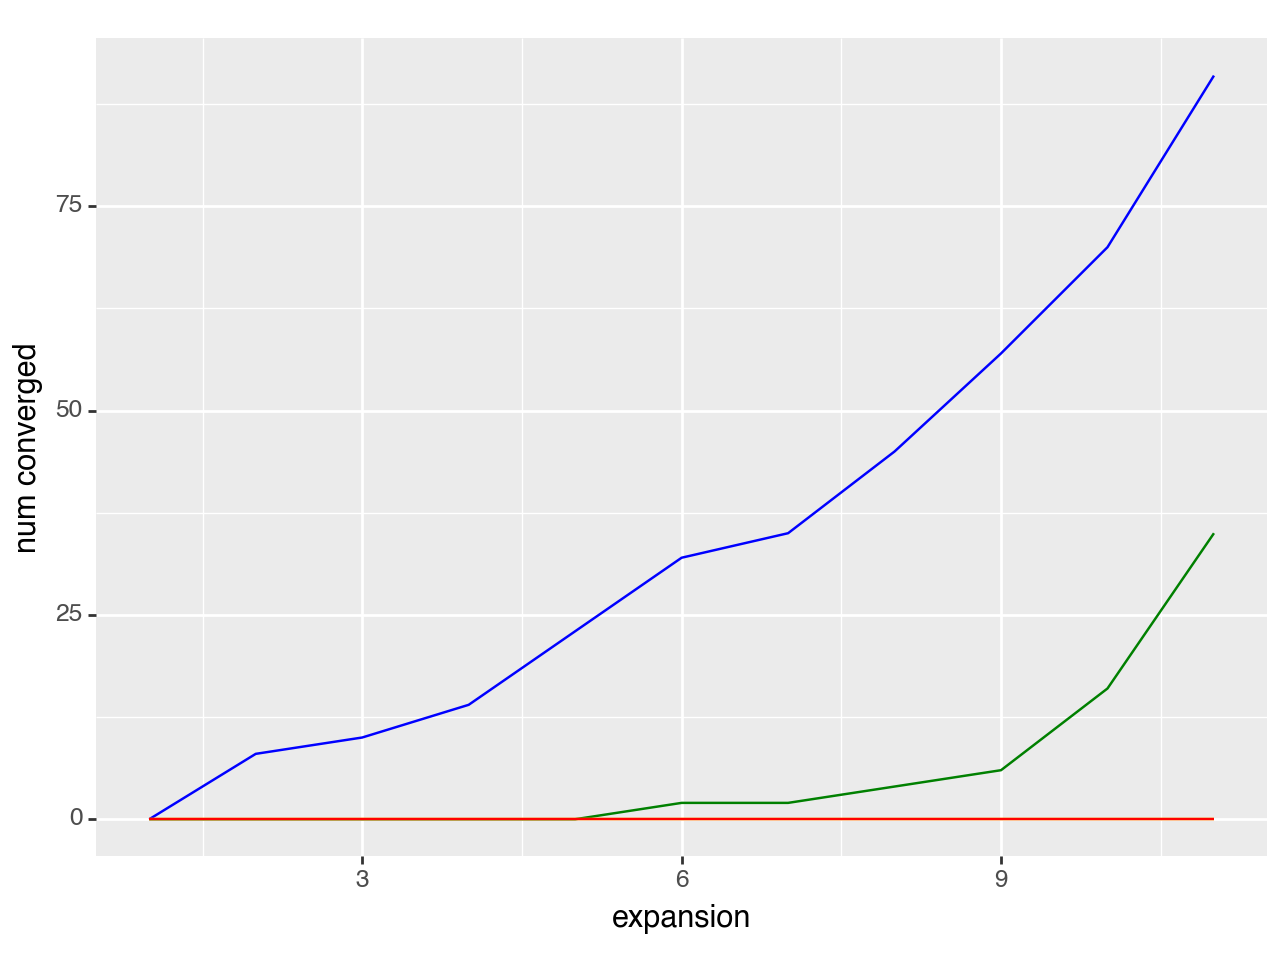

<Figure Size: (640 x 480)>

In [8]:
(
    pn.ggplot(
        df_kernel_evolution, 
        pn.aes(
            x="expansion", 
            # y="avg_converged_kernel_size",
            # y="num_converged_for_16",
        ),
    )
    # + pn.geom_point()
    + pn.geom_line(pn.aes(y="num_converged_for_1"), color="blue")
    + pn.geom_line(pn.aes(y="num_converged_for_10"), color="green")
    + pn.geom_line(pn.aes(y="num_converged_for_100"), color="yellow")
    + pn.geom_line(pn.aes(y="num_converged_for_1000"), color="red")
    + pn.ylab("num converged")
)

In [51]:
# Why not just choose the very last index always?

In [24]:
from collections import Counter
fields = Counter([field for pub in atl.publications.values() for field in pub.fields_of_study])
fields

Counter({'Physics': 20318,
         'Engineering': 7147,
         'Computer Science': 4722,
         'Mathematics': 4060,
         'Medicine': 2592,
         'Materials Science': 1461,
         'Environmental Science': 774,
         'Chemistry': 405,
         'Geology': 357,
         'Geography': 253,
         'Biology': 213,
         'Economics': 16,
         'History': 7,
         'Sociology': 4,
         'Political Science': 4,
         'Psychology': 4,
         'Business': 4,
         'Agricultural and Food Sciences': 4,
         'Education': 3,
         'Art': 3,
         'Philosophy': 3})

In [45]:
# con_d = int(kernels.shape[1]/2)
# print(f"Setting convergence degree to len(history)/2 = {con_d}.\n")

# NOTE: idea: what if we choose the con_d s.t. it's the first update where the _avg_ kernel size is >= kernel_size?

con_d = 1 # 1 = very last
kernel_size = 10

# Get all publications that have not changed neighborhoods up to kernel_size for the last con_d updates
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Low-redshift Lyman limit systems as diagnostics of cosmological inflows and outflows',
 'On the evolution of the H i column density distribution in cosmological simulations',
 'Massive molecular outflows and evidence for AGN feedback from CO observations',
 'The impact of different physical processes on the statistics of Lyman-limit and damped Lyman α absorbers',
 'Physical Models of Galaxy Formation in a Cosmological Framework',
 'Galaxies on FIRE (Feedback In Realistic Environments): stellar feedback explains cosmologically inefficient star formation',
 'Observing the circumgalactic medium of simulated galaxies through synthetic absorption spectra',
 'The CGM at Cosmic Noon with KCWI: Outflows from a Star-forming Galaxy at z = 2.071',
 'Feedback first: the surprisingly weak effects of magnetic fields, viscosity, conduction and metal diffusion on sub-L* galaxy formation',
 'Cosmological Simulations with TreeSPH']

In [46]:
# Filter to physics!
converged_pub_ids = [id for id in converged_pub_ids if "Physics" in atl[id].fields_of_study]
len(converged_pub_ids)

8417

In [47]:
crt = Cartographer(vectorizer=SciBERTVectorizer())

Using device: cpu.


In [48]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 8417 embeddings with batch size 1000.


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


Computing ['density', 'edginess'] for 8417 publications.


invalid value encountered in divide


In [49]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]

In [50]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs

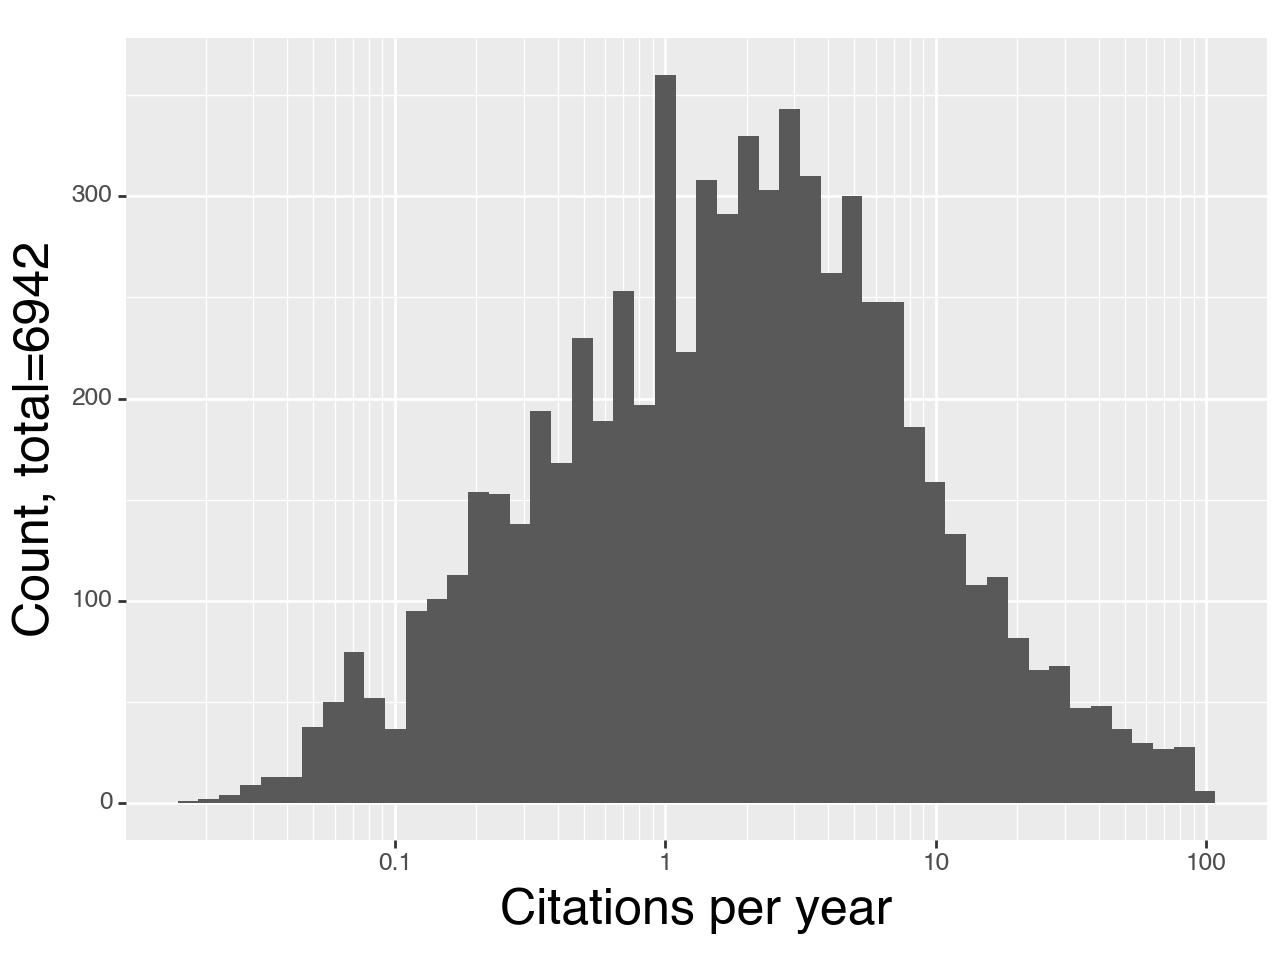

<Figure Size: (640 x 480)>

In [51]:
df_f = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= 100.)]

(
    pn.ggplot(
        # df,
        df_f,
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram(bins=50)
    + pn.scale_x_log10()
    + pn.xlab("Citations per year")
    + pn.ylab(f"Count, total={len(df_f)}")
    + pn.theme(
        axis_title=pn.element_text(size=18)
    )
)

In [72]:
# How many points are N cpy and below?
N = df["citations_per_year"].mean()
cpy = df["citations_per_year"]
print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

7073/8375 = (84.45373134328358 %) of publications received <= 7.040994166875714 cpy


In [73]:
# How many points are M density and below
M = df["density"].mean()
rho = df["density"]
print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")

0/8375 = (46.79402985074626 %) of publications have <= 20.37763464142536 density


In [74]:
df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
df_filtered = df_filtered[df_filtered["density"] <= M]

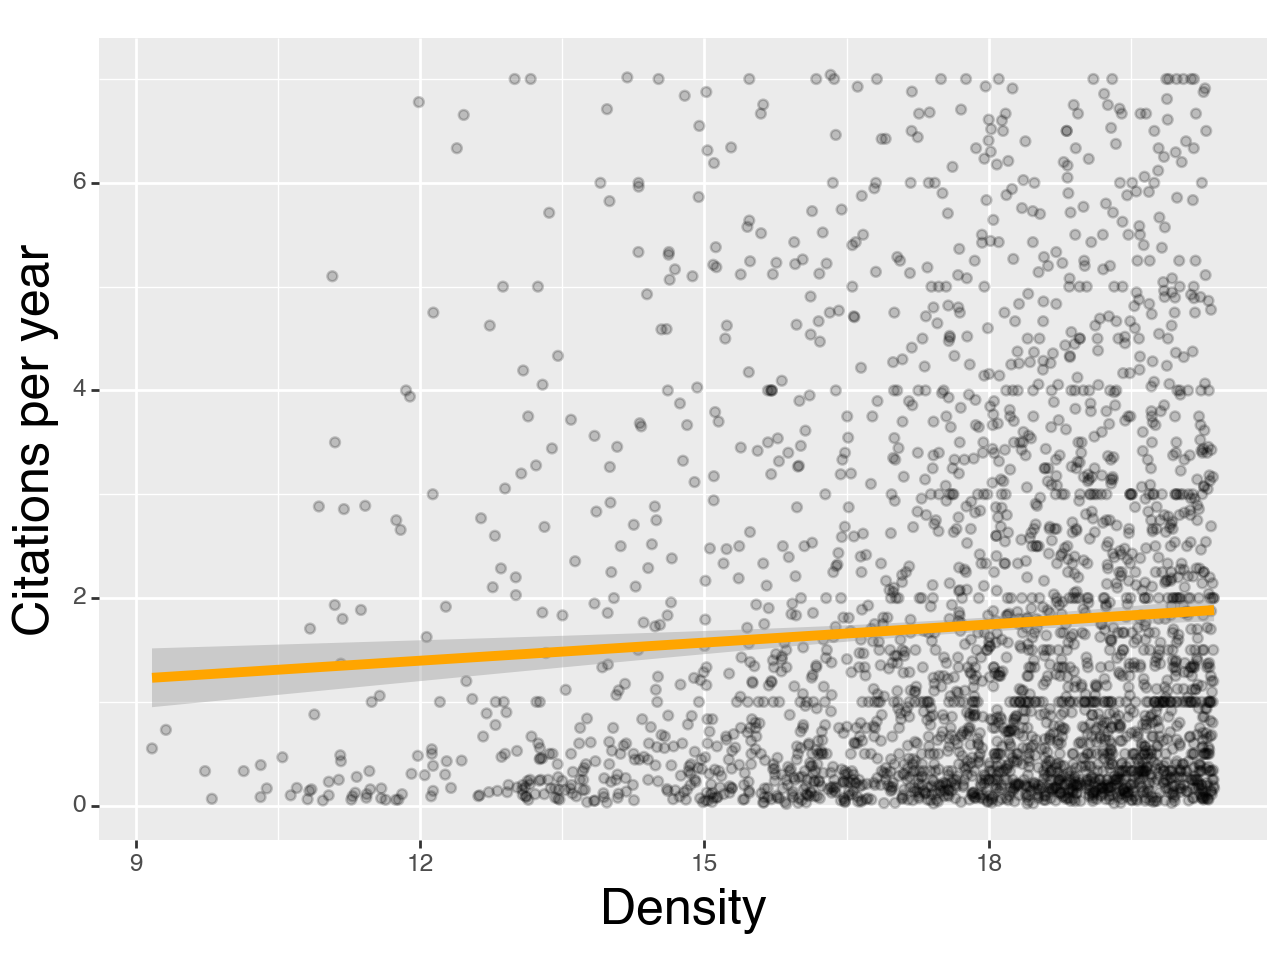

<Figure Size: (640 x 480)>

In [75]:
(
    pn.ggplot(
        df_filtered,
        mapping=pn.aes(
            # x="density", 
            x="edginess",
            y="citations_per_year",
        )
    )
    + pn.geom_point(
        alpha=0.2,
    )
    + pn.xlab("Density")
    # + pn.xlab("Asymmetry")
    + pn.ylab("Citations per year")
    + pn.geom_smooth(color="orange", size=2)
    + pn.theme(
        # axis_title_y=pn.element_blank(),
        axis_title=pn.element_text(size=18),
    )
)